In [1]:
import findspark
import pyspark

In [2]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
import os
os.getcwd()

'/home/jovyan'

In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [5]:
spark = SparkSession \
    .builder \
    .appName("Pysparkexample") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.sql.broadcastTimeout", "36000")\
    .getOrCreate()

In [6]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.4.1 pyspark-shell'

In [7]:
df_load = spark.read.csv('hdfs://192.168.122.206:8020/data/vol/depart/*.csv',header='true')

In [8]:
df_load.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- aircraft_aircrafttype_iatacode: string (nullable = true)
 |-- aircraft_aircrafttype_icaocode: string (nullable = true)
 |-- aircraft_aircrafttype_modelname: string (nullable = true)
 |-- airlines_airline_iatacode: string (nullable = true)
 |-- airlines_airline_icaocode: string (nullable = true)
 |-- airlines_airline_name: string (nullable = true)
 |-- airlines_operator_iatacode: string (nullable = true)
 |-- airlines_operator_icaocode: string (nullable = true)
 |-- airlines_operator_name: string (nullable = true)
 |-- airportresources_boarding_departurelounge: string (nullable = true)
 |-- airportresources_boarding_gates: string (nullable = true)
 |-- airportresources_checkin_checkinarea: string (nullable = true)
 |-- airportresources_checkin_desks: string (nullable = true)
 |-- airportresources_terminal: string (nullable = true)
 |-- airports_destination_iatacode: string (nullable = true)
 |-- airports_destination_icaocode: string (nullable

In [9]:
df=df_load.orderBy('last_update_fme', ascending = False).dropDuplicates(['aircraft_aircrafttype_iatacode','timestamps_eobt','airports_next_name'])

In [10]:
df_load_meteo = spark.read.csv('hdfs://192.168.122.206:8020/data/meteo/*.csv')

In [11]:
df_load_meteo.show(10000)

+----+------+------+---+-----+------+---+-----+-----+---+-----+-----+--------------------+-----+-------+----------+
| _c0|   _c1|   _c2|_c3|  _c4|   _c5|_c6|  _c7|  _c8|_c9| _c10| _c11|                _c12| _c13|   _c14|      _c15|
+----+------+------+---+-----+------+---+-----+-----+---+-----+-----+--------------------+-----+-------+----------+
|null|120000|103300|340|  5.1|278.96| 75|10000|   20|0.0|0.0.1|0.0.2|Arrondissement de...|45.75|   4.58|1580892780|
|   0|120000|102900|  0|  0.5|285.15| 81| 7000|   40|0.0|  0.0|  0.0|             Algiers|36.75|   3.04|1580892895|
|   1|120000|102300|340|  8.7|286.15| 62|10000|   40|0.0|  0.0|  0.0|              Annaba| 36.9|   7.77|1580893061|
|   2|120000|102500|320|  4.6|280.15| 70|10000|   75|0.0|  0.0|  0.0|               Batna|35.56|   6.17|1580892997|
|   3|120000|102100|330|  7.7|290.15| 29|10000|   20|0.0|  0.0|  0.0|              Biskra|34.85|   5.73|1580893061|
|   4|120000|102700|200|  1.5|282.74| 71| 7000|   75|0.0|  0.0|  0.0|   

In [12]:
df_load_meteo=df_load_meteo.withColumnRenamed("_c0","index").withColumnRenamed("_c1","numero").withColumnRenamed("_c2","pression").withColumnRenamed("_c3","direction_de_vent").withColumnRenamed("_c4","vitesse_de_vent").withColumnRenamed("_c5","temperature").withColumnRenamed("_c6","humidité").withColumnRenamed("_c7","visibilité").withColumnRenamed("_c8","nebulosite").withColumnRenamed("_c9","hauteur_neige").withColumnRenamed("_c10","precipitations_1").withColumnRenamed("_c11","precipitations_3").withColumnRenamed("_c12","nom").withColumnRenamed("_c13","longitude").withColumnRenamed("_c14","latitude").withColumnRenamed("_c15","timestamp") 

In [13]:
df_load_meteo=df_load_meteo.drop(df_load_meteo.index)

In [14]:
from pyspark.sql.functions import from_unixtime,from_utc_timestamp
func =  lambda x:from_unixtime(x, format='yyyy-MM-dd HH:mm:ss')
df_load_meteo=df_load_meteo.withColumn('timestamp',func(df_load_meteo['timestamp']))

In [15]:
df_load_meteo.filter(df_load_meteo.timestamp == '2020-01-20 14:38:29').show(10)

+------+--------+-----------------+---------------+-----------+--------+----------+----------+-------------+----------------+----------------+--------------------+---------+--------+-------------------+
|numero|pression|direction_de_vent|vitesse_de_vent|temperature|humidité|visibilité|nebulosite|hauteur_neige|precipitations_1|precipitations_3|                 nom|longitude|latitude|          timestamp|
+------+--------+-----------------+---------------+-----------+--------+----------+----------+-------------+----------------+----------------+--------------------+---------+--------+-------------------+
|120000|  103700|              350|            2.1|     278.67|      48|     10000|         1|          0.0|           0.0.1|           0.0.2|Arrondissement de...|    45.75|    4.58|2020-01-20 14:38:29|
|120000|  103700|              350|            2.1|     278.67|      48|     10000|         1|          0.0|             0.0|             0.0|Arrondissement de...|    45.75|    4.58|2020-0

In [16]:
df_load_meteo['timestamp'][0]

Column<b'timestamp[0]'>

In [17]:
df_load_meteo.select('nom').first()

Row(nom='Arrondissement de Lyon')

In [18]:
df_load_meteo=df_load_meteo.dropDuplicates(['nom','timestamp'])

In [19]:
import pyspark.sql.functions as F
df_meteo=df_load_meteo.withColumn("timestamp_30_before", df_load_meteo.timestamp - F.expr('INTERVAL 30 MINUTES') )
df_meteo=df_meteo.withColumn("timestamp_30_after", df_load_meteo.timestamp + F.expr('INTERVAL 30 MINUTES') )

In [20]:
df_Lyon_meteo=df_meteo.filter("nom = 'Arrondissement de Lyon'")

In [21]:
joined_df = df.join(df_Lyon_meteo, [df.timestamps_eobt < df_Lyon_meteo.timestamp_30_after,df_Lyon_meteo.timestamp_30_before < df.timestamps_eobt], how='inner')

In [22]:
joined_df=joined_df.dropDuplicates(['aircraft_aircrafttype_iatacode','timestamps_eobt','airports_next_name'])

In [23]:
joined_df=joined_df.orderBy('timestamps_eobt').select(['aircraft_aircrafttype_icaocode','flightnumbers_icaoflightnumber', 'airportresources_terminal','airports_destination_name','airlines_airline_name','airlines_operator_icaocode','airlines_airline_icaocode','countrytype_code','timestamps_sobt','timestamps_eobt','pression', 'direction_de_vent',
       'vitesse_de_vent', 'temperature', 'humidité', 'visibilité',
       'nebulosite', 'hauteur_neige'])

In [24]:
def change(row):
    row['day']=row['timestamps_sobt'].day
    row['day_of_the_week']=row['timestamps_sobt'].weekday
    row['month']=row["timestamps_sobt"].month
    row['year']=row["timestamps_sobt"].year
    row['hour']=row["timestamps_sobt"].hour
    row['minute']=row["timestamps_sobt"].minute
    if((row['timestamps_eobt']-row['timestamps_sobt']).seconds/60 > 0):
        row['delay']=int((row['timestamps_eobt']-row['timestamps_sobt']).seconds/60)
    else :
        row['delay']=0
    if(int(row['delay'])<=15):
        row['delayLabel']='[0-15]'
    elif(15<int(row['delay'])<=30) :
        row['delayLabel']='[15-30]'
    elif(30<int(row['delay'])<=45) :
        row['delayLabel']='[30-45]'
    elif(45<int(row['delay'])<=60) :
        row['delayLabel']='[45-60]'
    elif(60<int(row['delay'])<=75) :
        row['delayLabel']='[60-75]'
    elif(75<int(row['delay'])<=90) :
        row['delayLabel']='[75-90]'
    elif(105<int(row['delay'])<=120) :
        row['delayLabel']='[105-120]'
    elif(120<int(row['delay'])<=135) :
        row['delayLabel']='[120-135]'
    elif(90<int(row['delay'])<=105) :
        row['delayLabel']='[90-105]'
    elif(150<int(row['delay'])<=165) :
        row['delayLabel']='[150-165]'
    elif(165<int(row['delay'])<=180) :
        row['delayLabel']='[165-180]'
    elif(180<int(row['delay'])<=195) :
        row['delayLabel']='[180-195]'
    elif(210<int(row['delay'])<=225) :
        row['delayLabel']='[210-225]'
    elif(225<int(row['delay'])<=240) :
        row['delayLabel']='[225-240]'
    elif(240<int(row['delay'])<=255) :
        row['delayLabel']='[240-255]'
    elif(255<int(row['delay'])<=270) :
        row['delayLabel']='[255-270]'
    elif(270<int(row['delay'])<=285) :
        row['delayLabel']='[270-285]'
    elif(285<int(row['delay'])<=300) :
        row['delayLabel']='[285-300]'
    elif(195<int(row['delay'])<=210) :
        row['delayLabel']='[195-210]'
    else :
        row['delayLabel']='more then 4 hours'
    
    return row['delay']
            

In [25]:
from pyspark.sql.functions import *
diff_secs_col = col("timestamps_eobt").cast("long") - col("timestamps_sobt").cast("long")
joined_df = joined_df.withColumn( "delay", (unix_timestamp(col('timestamps_eobt')) - unix_timestamp(col('timestamps_sobt')))/60 )
joined_df=joined_df.withColumn('delayLabel', F.when(col('delay')<=15,'[0-15]').when(col('delay')<=30 ,'[15-30]').when(col('delay')<=45,'[30-45]').when(col('delay')<=60 ,'[45-60]').when(col('delay')<=75 ,'[60-75]').when(col('delay')<=90 ,'[75-90]').when(col('delay')<=105 ,'[90-105]').when(col('delay')<=120 ,'[105-120]').when(col('delay')<=135 ,'[120-135]').when(col('delay')<=150 ,'[135-150]').when(col('delay')<=165 ,'[150-165]').when(col('delay')<=180 ,'[165-180]').when(col('delay')<=195 ,'[180-195]').when(col('delay')<=210 ,'[195-210]').when(col('delay')<=225 ,'[210-225]').when(col('delay')<=240,'[225-240]').when(col('delay')<=255 ,'[240-255]').when(col('delay')<=270 ,'[255-270]').when(col('delay')<=285 ,'[275-285]').when(col('delay')<=300 ,'[280-300]').when(col('delay')<=315 ,'[300-315]').when(col('delay')<=330 ,'[315-330]').when(col('delay')<=345 ,'[330-345]').when(col('delay')<=360,'[345-360]').otherwise("more then 4 hours"))

In [26]:
F

<module 'pyspark.sql.functions' from '/usr/local/spark/python/pyspark/sql/functions.py'>

In [27]:
def changethedate(s):
    tab=s.split("-")
    if len(tab[1])==1:
        tab[1]='0'+tab[1]
    s=tab[0]+'-'+tab[1]+'-'+tab[2]
    return s
import json
import requests
import time
import pandas as pd
url="https://pomber.github.io/covid19/timeseries.json"
            #print(url)
response = requests.get(url)
data_json=response.json()

dd=[]
for d in data_json:
        for l in data_json[d]:
                l['pays']=d
                dd.append(l)

covid_df= spark.createDataFrame(dd)
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
func =  udf (lambda x: changethedate(x),StringType())
covid_df=covid_df.withColumn('new_date',func(covid_df['date']))
from pyspark.sql.types import DateType
func =  udf (lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'),DateType())
covid_df=covid_df.withColumn('date_obs',func(covid_df['new_date']))

#create data frame
covid_df=covid_df.select('pays','date_obs','confirmed')

In [28]:
covid_df=covid_df.filter(F.col('pays')=='France')

In [29]:
from pyspark.sql.functions import from_unixtime,from_utc_timestamp
func =  lambda x:pyspark.sql.functions.split(x, ' ')
joined_df=joined_df.withColumn('datedepart',func(joined_df['timestamps_sobt']).getItem(0))

In [30]:
df_Glob = joined_df.join(covid_df, [joined_df.datedepart==covid_df.date_obs], how='left')

In [31]:
df_Glob.show(10)

+------------------------------+------------------------------+-------------------------+-------------------------+---------------------+--------------------------+-------------------------+----------------+-------------------+-------------------+--------+-----------------+---------------+-----------+--------+----------+----------+-------------+-----+----------+----------+------+----------+---------+
|aircraft_aircrafttype_icaocode|flightnumbers_icaoflightnumber|airportresources_terminal|airports_destination_name|airlines_airline_name|airlines_operator_icaocode|airlines_airline_icaocode|countrytype_code|    timestamps_sobt|    timestamps_eobt|pression|direction_de_vent|vitesse_de_vent|temperature|humidité|visibilité|nebulosite|hauteur_neige|delay|delayLabel|datedepart|  pays|  date_obs|confirmed|
+------------------------------+------------------------------+-------------------------+-------------------------+---------------------+--------------------------+-------------------------+--

In [32]:
from pyspark.sql.functions import coalesce
df_Glob=df_Glob.withColumn('date_obs', coalesce('date_obs', 'datedepart'))
df_Glob=df_Glob.na.fill({'pays': 'France', 'confirmed': 0})

In [33]:
from pyspark.sql.functions import isnan, when, count, col

df_Glob.select([count(when(isnan(c), c)).alias(c) for c in df_Glob.columns]).show()

+------------------------------+------------------------------+-------------------------+-------------------------+---------------------+--------------------------+-------------------------+----------------+---------------+---------------+--------+-----------------+---------------+-----------+--------+----------+----------+-------------+-----+----------+----------+----+--------+---------+
|aircraft_aircrafttype_icaocode|flightnumbers_icaoflightnumber|airportresources_terminal|airports_destination_name|airlines_airline_name|airlines_operator_icaocode|airlines_airline_icaocode|countrytype_code|timestamps_sobt|timestamps_eobt|pression|direction_de_vent|vitesse_de_vent|temperature|humidité|visibilité|nebulosite|hauteur_neige|delay|delayLabel|datedepart|pays|date_obs|confirmed|
+------------------------------+------------------------------+-------------------------+-------------------------+---------------------+--------------------------+-------------------------+----------------+---------

In [34]:
trainDF=df_Glob.orderBy('timestamps_eobt').select(['aircraft_aircrafttype_icaocode','flightnumbers_icaoflightnumber', 'airportresources_terminal','airports_destination_name','airlines_airline_name','airlines_operator_icaocode','airlines_airline_icaocode','countrytype_code','pression', 'direction_de_vent',
       'vitesse_de_vent', 'temperature', 'humidité', 'visibilité',
       'nebulosite', 'hauteur_neige','delay','pays','date_obs','confirmed']).toPandas()

In [35]:
trainDF=trainDF.astype({'pression': 'float64'})
trainDF=trainDF.astype({'direction_de_vent': 'float64'})
trainDF=trainDF.astype({'vitesse_de_vent': 'float64'})
trainDF=trainDF.astype({'temperature': 'float64'})
trainDF=trainDF.astype({'confirmed': 'float64'})
trainDF=trainDF.astype({'humidité': 'float64'})
trainDF=trainDF.astype({'visibilité': 'float64'})
trainDF=trainDF.astype({'hauteur_neige': 'float64'})
trainDF=trainDF.astype({'nebulosite': 'float64'})

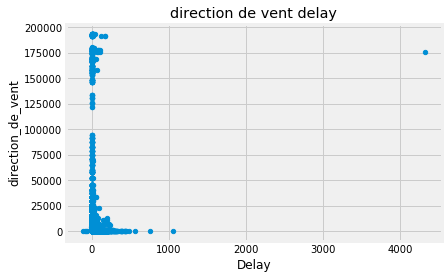

In [36]:
import numpy as np
import matplotlib.pyplot as plt


colors = (0,0,0)
area = np.pi*6


# Plot
plt.scatter(trainDF["delay"],trainDF.sort_values(by='confirmed', ascending=True)["confirmed"] , s=area, alpha=1)
plt.title('direction de vent delay')
plt.xlabel('Delay')
plt.ylabel('direction_de_vent')
plt.show()

In [37]:
trainDF.dtypes

aircraft_aircrafttype_icaocode     object
flightnumbers_icaoflightnumber     object
airportresources_terminal          object
airports_destination_name          object
airlines_airline_name              object
airlines_operator_icaocode         object
airlines_airline_icaocode          object
countrytype_code                   object
pression                          float64
direction_de_vent                 float64
vitesse_de_vent                   float64
temperature                       float64
humidité                          float64
visibilité                        float64
nebulosite                        float64
hauteur_neige                     float64
delay                             float64
pays                               object
date_obs                           object
confirmed                         float64
dtype: object

In [38]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(trainDF) for column in ['aircraft_aircrafttype_icaocode','flightnumbers_icaoflightnumber', 'airportresources_terminal','airports_destination_name','airlines_airline_name','airlines_operator_icaocode','airlines_airline_icaocode','countrytype_code'] ]

pipeline = Pipeline(stages=indexers)
trainDF_r = pipeline.fit(trainDF).transform(trainDF)


AttributeError: 'DataFrame' object has no attribute '_jdf'

In [30]:
trainDF_r.printSchema()

root
 |-- aircraft_aircrafttype_icaocode: string (nullable = true)
 |-- flightnumbers_icaoflightnumber: string (nullable = true)
 |-- airportresources_terminal: string (nullable = true)
 |-- airports_destination_name: string (nullable = true)
 |-- airlines_airline_name: string (nullable = true)
 |-- airlines_operator_icaocode: string (nullable = true)
 |-- airlines_airline_icaocode: string (nullable = true)
 |-- countrytype_code: string (nullable = true)
 |-- pression: string (nullable = true)
 |-- direction_de_vent: string (nullable = true)
 |-- vitesse_de_vent: string (nullable = true)
 |-- temperature: string (nullable = true)
 |-- humidité: string (nullable = true)
 |-- visibilité: string (nullable = true)
 |-- nebulosite: string (nullable = true)
 |-- hauteur_neige: string (nullable = true)
 |-- delay: double (nullable = true)
 |-- aircraft_aircrafttype_icaocode_index: double (nullable = false)
 |-- flightnumbers_icaoflightnumber_index: double (nullable = false)
 |-- airportresour

In [32]:
from pyspark.ml.feature import IndexToString, StringIndexer

df = spark.createDataFrame(
    [(0, "a"), (1, "b"), (2, "c"), (3, "a"), (4, "a"), (5, "c")],
    ["id", "category"])

indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
model = indexer.fit(df)
indexed = model.transform(df)

print("Transformed string column '%s' to indexed column '%s'"
      % (indexer.getInputCol(), indexer.getOutputCol()))
indexed.show()

print("StringIndexer will store labels in output column metadata\n")

converter = IndexToString(inputCol="categoryIndex", outputCol="originalCategory")
converted = converter.transform(indexed)

print("Transformed indexed column '%s' back to original string column '%s' using "
      "labels in metadata" % (converter.getInputCol(), converter.getOutputCol()))
converted.select("id", "categoryIndex", "originalCategory").show()

Transformed string column 'category' to indexed column 'categoryIndex'
+---+--------+-------------+
| id|category|categoryIndex|
+---+--------+-------------+
|  0|       a|          0.0|
|  1|       b|          2.0|
|  2|       c|          1.0|
|  3|       a|          0.0|
|  4|       a|          0.0|
|  5|       c|          1.0|
+---+--------+-------------+

StringIndexer will store labels in output column metadata

Transformed indexed column 'categoryIndex' back to original string column 'originalCategory' using labels in metadata
+---+-------------+----------------+
| id|categoryIndex|originalCategory|
+---+-------------+----------------+
|  0|          0.0|               a|
|  1|          2.0|               b|
|  2|          1.0|               c|
|  3|          0.0|               a|
|  4|          0.0|               a|
|  5|          1.0|               c|
+---+-------------+----------------+



In [63]:
from pyspark.sql.types import DoubleType
trainDF_r = trainDF_r.withColumn("pression", trainDF_r["pression"].cast(DoubleType()))
trainDF_r = trainDF_r.withColumn("direction_de_vent", trainDF_r["direction_de_vent"].cast(DoubleType()))
trainDF_r = trainDF_r.withColumn("vitesse_de_vent", trainDF_r["vitesse_de_vent"].cast(DoubleType()))
trainDF_r = trainDF_r.withColumn("temperature", trainDF_r["temperature"].cast(DoubleType()))
trainDF_r = trainDF_r.withColumn("humidité", trainDF_r["humidité"].cast(DoubleType()))
trainDF_r = trainDF_r.withColumn("visibilité", trainDF_r["visibilité"].cast(DoubleType()))
trainDF_r = trainDF_r.withColumn("nebulosite", trainDF_r["nebulosite"].cast(DoubleType()))
trainDF_r = trainDF_r.withColumn("hauteur_neige", trainDF_r["hauteur_neige"].cast(DoubleType()))

In [64]:
trainDF1=trainDF_r.select('pression',
 'direction_de_vent',
 'vitesse_de_vent',
 'temperature',
 'humidité',
 'visibilité',
 'nebulosite',
 'hauteur_neige',
 'aircraft_aircrafttype_icaocode_index',
 'flightnumbers_icaoflightnumber_index',
 'airportresources_terminal_index',
 'airports_destination_name_index',
 'airlines_airline_name_index',
 'airlines_operator_icaocode_index',
 'airlines_airline_icaocode_index',
 'countrytype_code_index','delay')

In [65]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['pression',
 'direction_de_vent',
 'vitesse_de_vent',
 'temperature',
 'humidité',
 'visibilité',
 'nebulosite',
 'hauteur_neige',
 'aircraft_aircrafttype_icaocode_index',
 'flightnumbers_icaoflightnumber_index',
 'airportresources_terminal_index',
 'airports_destination_name_index',
 'airlines_airline_name_index',
 'airlines_operator_icaocode_index',
 'airlines_airline_icaocode_index',
 'countrytype_code_index'],
    outputCol="features")
trainDF1 = assembler.transform(trainDF1)

In [ ]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



# generate the train/test split.
(train, test) = trainDF1.randomSplit([0.8, 0.2])

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True,labelCol = 'delayLabel_index',featuresCol = 'features')

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr,labelCol = 'delayLabel_index',featuresCol = 'features')

# train the multiclass model.
ovrModel = ovr.fit(train)

# score the model on test data.
predictions = ovrModel.transform(test)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy",labelCol = 'delayLabel_index')

# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

In [ ]:
trainDF1.select("delayLabel").show(10)

In [41]:
trainDF.select("delayLabel").distinct().show()

+-----------------+
|       delayLabel|
+-----------------+
|          [45-60]|
|        [300-315]|
|          [75-90]|
|          [30-45]|
|        [120-135]|
|more then 4 hours|
|        [225-240]|
|           [0-15]|
|        [195-210]|
|        [210-225]|
|        [330-345]|
|         [90-105]|
|        [255-270]|
|        [275-285]|
|        [280-300]|
|        [135-150]|
|          [60-75]|
|        [105-120]|
|        [180-195]|
|        [315-330]|
+-----------------+
only showing top 20 rows



In [51]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Split the data into train and test
splits = trainDF1.randomSplit([0.75, 0.25], 1234)
train = splits[0]
test = splits[1]

# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [16, 16, 13 ,17, 24]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234,labelCol = 'delayLabel_index',featuresCol = 'features')

# train the model
model = trainer.fit(train)

# compute accuracy on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "delayLabel_index")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy",labelCol = 'delayLabel_index')
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.7740192623913554


In [81]:
y_true = predictionAndLabels.select(['delayLabel_index']).collect()
y_pred = predictionAndLabels.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87      3295
         1.0       0.00      0.00      0.00       362
         2.0       0.00      0.00      0.00       191
         3.0       0.00      0.00      0.00       129
         4.0       0.00      0.00      0.00        87
         5.0       0.00      0.00      0.00        53
         6.0       0.00      0.00      0.00        46
         7.0       0.00      0.00      0.00        28
         8.0       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00        18
        10.0       0.00      0.00      0.00         7
        11.0       0.00      0.00      0.00         5
        12.0       0.00      0.00      0.00         4
        13.0       0.00      0.00      0.00         5
        14.0       0.00      0.00      0.00         4
        15.0       0.00      0.00      0.00         3
        16.0       0.00      0.00      0.00         1
        18.0       0.00    

In [73]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator


# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(trainDF1)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = trainDF1.randomSplit([0.75, 0.25])

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="indexedFeatures",labelCol = 'delay',numTrees=3, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=8, maxBins=380)

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "delay", "indexedFeatures").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol = 'delay', predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[1]

+-----------------+-----+--------------------+
|       prediction|delay|     indexedFeatures|
+-----------------+-----+--------------------+
|6.986494703154084| 10.0|[103700.0,330.0,2...|
|6.986494703154084|  5.0|[103700.0,330.0,2...|
|6.235133127365586|  0.0|[103700.0,330.0,2...|
|             75.5| 21.0|[103700.0,330.0,3...|
|7.478405491429455|  0.0|[103700.0,330.0,3...|
+-----------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 30.2123


In [80]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import ChiSqSelector


# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(trainDF1)

selector = ChiSqSelector(numTopFeatures=1, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="delay")
result = selector.fit(trainDF1).transform(trainDF1)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = result.randomSplit([0.7, 0.3])

# Train a GBT model.
gbt = GBTRegressor(featuresCol="selectedFeatures",labelCol = 'delay', maxIter=10, maxBins=380)

# Chain indexer and GBT in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, gbt])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "delay", "selectedFeatures").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="delay", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+-------------+-----+----------------+
|   prediction|delay|selectedFeatures|
+-------------+-----+----------------+
|10.7299262321|  6.0|         [330.0]|
|10.7299262321|  5.0|         [330.0]|
|10.7299262321| 15.0|         [330.0]|
|10.7299262321|  0.0|         [330.0]|
|10.7299262321| 10.0|         [330.0]|
+-------------+-----+----------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 36.0819
